In [7]:
from tensorflow import ConfigProto, InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [1]:
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt

train_path = 'images/train/'
test_path = 'images/test/'
batch_size = 16
image_size = 224
num_class = 8


train_datagen = ImageDataGenerator(validation_split=0.3,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(
                        directory=train_path,
                        target_size=(image_size,image_size),
                        batch_size=batch_size,
                        class_mode='categorical',
                        color_mode='rgb',
                        shuffle=True)

Using TensorFlow backend.


Found 6899 images belonging to 8 classes.


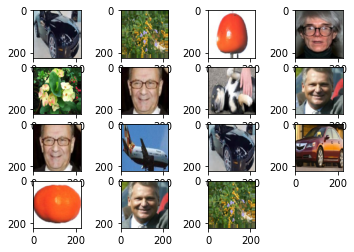

In [2]:
x_batch, y_batch = train_generator.next()

fig=plt.figure()
columns = 4
rows = 4
for i in range(1, columns*rows):
    num = np.random.randint(batch_size)
    image = x_batch[num].astype(np.int)
    fig.add_subplot(rows, columns, i)
    plt.imshow(image)
plt.show()

In [3]:
import keras
from keras.models import Model, load_model
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16


#Load the VGG model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

print(base_model.summary())

    # Freeze the layers 
for layer in base_model.layers:
    layer.trainable = False
 
# # Create the model
model = keras.models.Sequential()

# # Add the vgg convolutional base model
model.add(base_model)
 
# # Add new layers
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(num_class, activation='softmax'))
 
# # Show a summary of the model. Check the number of trainable parameters    
print(model.summary())

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_____________________________________________


Epoch 1/10
432/431 [==============================] - 217s 503ms/step - loss: 0.4632 - accuracy: 0.9594
Epoch 2/10
432/431 [==============================] - 107s 247ms/step - loss: 0.1072 - accuracy: 0.9861
Epoch 3/10
432/431 [==============================] - 104s 242ms/step - loss: 0.0424 - accuracy: 0.9936
Epoch 4/10
432/431 [==============================] - 112s 259ms/step - loss: 0.0439 - accuracy: 0.9936
Epoch 5/10
432/431 [==============================] - 111s 257ms/step - loss: 0.0345 - accuracy: 0.9951
Epoch 6/10
432/431 [==============================] - 107s 248ms/step - loss: 0.0188 - accuracy: 0.9962
Epoch 7/10
432/431 [==============================] - 104s 242ms/step - loss: 0.0122 - accuracy: 0.9978
Epoch 8/10
432/431 [==============================] - 98s 227ms/step - loss: 0.0105 - accuracy: 0.9983
Epoch 9/10
432/431 [==============================] - 112s 259ms/step - loss: 0.0085 - accuracy: 0.9980
Epoch 10/10
432/431 [==============================] - 109s 252m

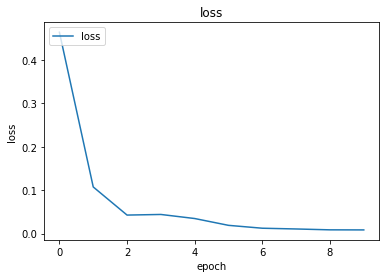

In [4]:
# # Compile the model
from keras.optimizers import SGD

model.compile(loss='categorical_crossentropy',
          optimizer=SGD(lr=1e-3),
          metrics=['accuracy'])

# # Start the training process
# model.fit(x_train, y_train, validation_split=0.30, batch_size=32, epochs=50, verbose=2)

# # #save the model
# model.save('catdog.h5')

history = model.fit_generator(train_generator, steps_per_epoch=train_generator.n/batch_size, epochs=10)
        
model.save('fine_tune.h5')

# summarize history for accuracy
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss'], loc='upper left')
plt.show()

Found 6899 images belonging to 8 classes.
Found 14 images belonging to 8 classes.


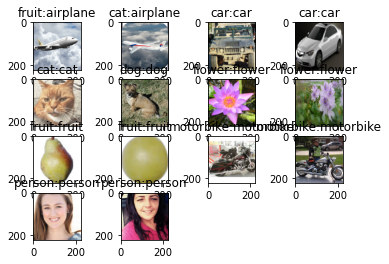

In [5]:
model = load_model('fine_tune.h5')

test_datagen = ImageDataGenerator()
train_generator = train_datagen.flow_from_directory(
                        directory=train_path,
                        target_size=(image_size,image_size),
                        batch_size=batch_size,
                        class_mode='categorical',
                        color_mode='rgb',
                        shuffle=True)

test_generator = test_datagen.flow_from_directory(
                        directory=test_path, 
                        target_size=(image_size, image_size),
                        color_mode='rgb',
                        shuffle=False,
                        class_mode='categorical',
                        batch_size=1)

filenames = test_generator.filenames
nb_samples = len(filenames)

fig=plt.figure()
columns = 4
rows = 4
for i in range(1, columns*rows -1):
    x_batch, y_batch = test_generator.next()

    name = model.predict(x_batch)
    name = np.argmax(name, axis=-1)
    true_name = y_batch
    true_name = np.argmax(true_name, axis=-1)

    label_map = (test_generator.class_indices)
    label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
    predictions = [label_map[k] for k in name]
    true_value = [label_map[k] for k in true_name]

    image = x_batch[0].astype(np.int)
    fig.add_subplot(rows, columns, i)
    plt.title(str(predictions[0]) + ':' + str(true_value[0]))
    plt.imshow(image)
plt.show()